In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import datetime
sns.set()
from files.sb_utils import save_file

In [2]:
anime_df = pd.read_csv('../Data/anime_data.csv')

In [3]:
anime_df.head().T

,0,1,2,3,4
anime_id,5114,11061,38524,9253,28851
title,Fullmetal Alchemist: Brotherhood,Hunter x Hunter (2011),Shingeki no Kyojin Season 3 Part 2,Steins;Gate,Koe no Katachi
type,tv,tv,tv,tv,movie
score,9.1,9.04,9.05,9.07,8.94
scored_by,2037075,1671587,1491491,1348232,1540277
status,finished_airing,finished_airing,finished_airing,finished_airing,finished_airing
episodes,64.0,148.0,10.0,24.0,1.0
source,manga,manga,manga,visual_novel,manga
rating,r,pg_13,r,pg_13,pg_13
sfw,True,True,True,True,True


Before we start trining, I will remove the title and anime ID and create a new DF

In [4]:
new_anime_df = anime_df.drop(['anime_id', 'title', 'created_at', 'real_end_date', 'scored_by', 'status', 'episodes','start_year', 'start_season', 'sfw'], axis =1)
new_anime_df.head()
new_anime_df.dropna(how = 'all')

,type,score,source,rating,genres,themes,demographics,studios,producers,licensors
0,tv,9.10,manga,r,"Action, Adventure, Drama, Fantasy",Military,Shounen,Bones,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America"
1,tv,9.04,manga,pg_13,"Action, Adventure, Fantasy",NaN,Shounen,Madhouse,"VAP, Nippon Television Network, Shueisha",VIZ Media
2,tv,9.05,manga,r,"Action, Drama","Gore, Military, Survival",Shounen,Wit Studio,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation
3,tv,9.07,visual_novel,pg_13,"Drama, Sci-Fi, Suspense","Psychological, Time Travel",NaN,White Fox,"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation
4,movie,8.94,manga,pg_13,"Award Winning, Drama",Romantic Subtext,Shounen,Kyoto Animation,"Shochiku, Pony Canyon, Kodansha, ABC Animation...","Eleven Arts, NYAV Post"
...,...,...,...,...,...,...,...,...,...,...
14459,movie,5.01,original,pg_13,Slice of Life,NaN,NaN,NaN,NaN,NaN
14460,ona,4.84,NaN,g,Comedy,NaN,NaN,Kachidoki Studio,NaN,NaN
14461,movie,4.90,original,g,Avant Garde,NaN,NaN,NaN,NaN,NaN
14462,ona,5.08,radio,g,Comedy,NaN,NaN,NaN,NaN,NaN


# Make dummy variables for our categorical variables

In [5]:
genre_dummies = new_anime_df['genres'].str.get_dummies(', ').add_prefix('genre_').astype(bool)
df = pd.concat([new_anime_df, genre_dummies], axis=1)
df =df.drop('genres', axis = 1)
theme_dummies = new_anime_df['themes'].str.get_dummies(', ').add_prefix('theme_').astype(bool)
df = pd.concat([df, theme_dummies], axis=1)
df =df.drop('themes', axis = 1)
studio_dummies = new_anime_df['studios'].str.get_dummies(', ').add_prefix('studio_').astype(bool)
df = pd.concat([df, studio_dummies], axis=1)
df =df.drop('studios', axis = 1)
#print(df.head())
#dfo=new_anime_df.select_dtypes(include=['object']) # select object type columns
#dfo
#df = pd.concat([new_anime_df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)
#df.head()
df

,type,score,source,rating,demographics,producers,licensors,genre_Action,genre_Adventure,genre_Avant Garde,...,studio_iDRAGONS Creative Studio,studio_ixtl,studio_l-a-unch・BOX,studio_monofilmo,studio_production doA,studio_studio MOTHER,studio_team Yamahitsuji,studio_teamKG,studio_ufotable,studio_yell
0,tv,9.10,manga,r,Shounen,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,tv,9.04,manga,pg_13,Shounen,"VAP, Nippon Television Network, Shueisha",VIZ Media,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,tv,9.05,manga,r,Shounen,"Production I.G, Dentsu, Mainichi Broadcasting ...",Funimation,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,tv,9.07,visual_novel,pg_13,NaN,"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,movie,8.94,manga,pg_13,Shounen,"Shochiku, Pony Canyon, Kodansha, ABC Animation...","Eleven Arts, NYAV Post",False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14459,movie,5.01,original,pg_13,NaN,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14460,ona,4.84,NaN,g,NaN,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14461,movie,4.90,original,g,NaN,NaN,NaN,False,False,True,...,False,False,False,False,False,False,False,False,False,False
14462,ona,5.08,radio,g,NaN,NaN,NaN,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [6]:
pro_dummies = new_anime_df['producers'].str.get_dummies(', ').add_prefix('prod_').astype(bool)
df = pd.concat([df, pro_dummies], axis=1)
df =df.drop('producers', axis = 1)

In [7]:
lic_dummies = new_anime_df['licensors'].str.get_dummies(', ').add_prefix('Licen_').astype(bool)
df = pd.concat([df, lic_dummies], axis=1)
df =df.drop('licensors', axis = 1)

In [8]:
# df without genres, themes, producers, licensors
#df_no4 = new_anime_df.drop(['themes', 'themes', 'producers', 'licensors', 'studios'],axis = 1)
dfo=df.select_dtypes(include=['object']) # select object type columns
dfo
df = pd.concat([df.drop(dfo, axis=1), pd.get_dummies(dfo)], axis=1)
df.head().T


,0,1,2,3,4
score,9.1,9.04,9.05,9.07,8.94
genre_Action,True,True,True,False,False
genre_Adventure,True,True,False,False,False
genre_Avant Garde,False,False,False,False,False
genre_Award Winning,False,False,False,False,True
...,...,...,...,...,...
"demographics_Kids, Shoujo",False,False,False,False,False
"demographics_Kids, Shounen",False,False,False,False,False
demographics_Seinen,False,False,False,False,False
demographics_Shoujo,False,False,False,False,False


In [9]:
scaler = MinMaxScaler((0,1))
scaled_df= scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df) 

In [10]:
scaled_df

,0,1,2,3,4,5,6,7,8,9,...,2471,2472,2473,2474,2475,2476,2477,2478,2479,2480
0,1.000000,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.991724,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.993103,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.995862,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.977931,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14459,0.435862,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14460,0.412414,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14461,0.420690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14462,0.445517,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X = df.drop('score', axis =1)
y = df['score']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

# pipe for linear regression

In [13]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    LinearRegression()
)

In [14]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('linearregression', LinearRegression())])

In [15]:
y_tr_pred = pipe.predict(X_train)
y_te_pred = pipe.predict(X_test)

In [16]:
#check R^2 score, the proportion of variance in the dependent variable by the independent variable
print("Training set R2 score: ",r2_score(y_train, y_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, y_te_pred))

Training set R2 score:  0.6873982603422604
Testing set R2 score:  -1.7627066982220555e+21


In [17]:
# check the Mean absolute error, average of absolute differences between predicted vs actual values
print("MAE of training set: ",mean_absolute_error(y_train, y_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, y_te_pred))

MAE of training set:  0.37097146892208493
MAE of testing set:  4574511652.036074


In [18]:
#check RMSE, the lower the better, lower indicates a better model
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, y_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, y_te_pred)))

RMSE of training set:  0.5041931617809288
RMSE of the testing set:  37861986378.21404


### Test linear pipeline selecting a certain number of features

In [19]:
pipe2 = make_pipeline( SimpleImputer(strategy='median'), 
    #StandardScaler(),
    SelectKBest(score_func = f_regression, k=15),
    LinearRegression())

In [20]:
pipe2.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('selectkbest',
                 SelectKBest(k=15,
                             score_func=<function f_regression at 0x000001AFA27BBC40>)),
                ('linearregression', LinearRegression())])

In [21]:
y2_tr_pred = pipe2.predict(X_train)
y2_te_pred = pipe2.predict(X_test)

In [22]:
#check R^2 score, higher is better
print("Training set R2 score: ",r2_score(y_train, y2_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, y2_te_pred))

Training set R2 score:  0.3271335841700508
Testing set R2 score:  0.3394617548705491


In [23]:
# check the Mean absolute error, lower the better
print("MAE of training set: ",mean_absolute_error(y_train, y2_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, y2_te_pred))

MAE of training set:  0.5808243758552676
MAE of testing set:  0.5744260725516979


In [24]:
#check RMSE, the lower the better, lower indicates a better model
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, y2_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, y2_te_pred)))

RMSE of training set:  0.7397171402912419
RMSE of the testing set:  0.7329297522884628


Okay, so using only 15 features that are considered statically significant already shows us better results!

### Hypertuning the Linear Regression using grid search

In [25]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k,
               'simpleimputer__strategy': ['mean', 'median']}


In [26]:
from sklearn.model_selection import RandomizedSearchCV


lr_search_cv = RandomizedSearchCV(pipe2, grid_params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

In [27]:
lr_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('selectkbest',
                                              SelectKBest(k=15,
                                                          score_func=<function f_regression at 0x000001AFA27BBC40>)),
                                             ('linearregression',
                                              LinearRegression())]),
                   n_jobs=-1,
                   param_distributions={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7,
                                                           8, 9, 10, 11, 12, 13,
                                                           14, 15, 16, 17, 18,
                                                           19, 20, 21, 22, 23,
                                                           24, 25, 26, 27, 28,
                                                           29, 30, ...],
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   scoring='neg_mean_squared_error')

In [28]:
lr_search_cv.best_params_

{'simpleimputer__strategy': 'median', 'selectkbest__k': 160}

In [29]:
selected = lr_search_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_search_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

Licen_NIS America              1.801527e+12
Licen_GKIDS                    8.994472e-01
prod_Sony Music Solutions      7.347551e-01
studio_Kyoto Animation         7.320731e-01
rating_rx                      6.421505e-01
                                   ...     
prod_Five Ways                -8.760363e-01
prod_Obtain Future            -1.300103e+00
prod_Idea Factory             -1.321455e+00
prod_Kuri Jikken Manga Kobo   -1.344124e+00
Licen_Inc.                    -1.801527e+12
Length: 160, dtype: float64

In [30]:
score_mean = lr_search_cv.cv_results_['mean_test_score']
score_std = lr_search_cv.cv_results_['std_test_score']
print(score_mean)
print(score_std)

[-6.41982593e+19 -4.82164592e+20 -1.28345729e+20 -2.61009035e+20
 -5.15327347e+20 -5.37139484e+21 -3.42169777e+20 -5.03574713e+22
 -4.37663095e-01 -5.79763011e+19]
[1.28306243e+20 8.79977913e+20 1.68091502e+20 2.82557049e+20
 9.03300844e+20 4.62416058e+21 4.16825217e+20 9.97967297e+22
 1.83934466e-02 1.09810346e+20]


Lets's use the optimal parameters 

In [31]:
pipe3 = make_pipeline( SimpleImputer(strategy='mean'), 
    SelectKBest(score_func = f_regression, k=244),
    LinearRegression())

In [32]:
pipe3.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('selectkbest',
                 SelectKBest(k=244,
                             score_func=<function f_regression at 0x000001AFA27BBC40>)),
                ('linearregression', LinearRegression())])

In [33]:
y3_tr_pred = pipe3.predict(X_train)
y3_te_pred = pipe3.predict(X_test)

In [34]:
print("Training set R2 score: ",r2_score(y_train, y3_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, y3_te_pred))

Training set R2 score:  0.5236149450226775
Testing set R2 score:  0.49922844519865917


In [35]:
print("MAE of training set: ",mean_absolute_error(y_train, y3_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, y3_te_pred))

MAE of training set:  0.4833688444273289
MAE of testing set:  0.4922444700865678


In [36]:
#check RMSE, the lower the better, lower indicates a better model
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, y3_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, y3_te_pred)))

RMSE of training set:  0.622415386452832
RMSE of the testing set:  0.6381653110002055


Cross validate

In [37]:
cv_scores_test= cross_val_score(pipe3, X_test, y_test, cv=5)
cv_scores_train= cross_val_score(pipe3, X_train, y_train, cv=5)

In [38]:
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()

In [39]:
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))

Mean cross validation test score: -9.653828973576743e+20
Mean cross validation train score: 0.4857273525186023
Standard deviation in cv test scores: 1.456862415071691e+21


# Random Forest model

In [40]:
RF_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(random_state=47)
)

In [41]:
RF_pipe.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=47))])

In [42]:
yRF_tr_pred = RF_pipe.predict(X_train)
yRF_te_pred = RF_pipe.predict(X_test)

In [43]:
#higher the better
print("Training set R2 score: ",r2_score(y_train, yRF_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, yRF_te_pred))

Training set R2 score:  0.9253423869801973
Testing set R2 score:  0.5590318503756743


In [44]:
# lower the better
print("MAE of training set: ",mean_absolute_error(y_train, yRF_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, yRF_te_pred))

MAE of training set:  0.18050868170710235
MAE of testing set:  0.443535481225291


In [59]:
#check RMSE, the lower the better, lower indicates a better model
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, yRF_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, yRF_te_pred)))

RMSE of training set:  0.246398639816502
RMSE of the testing set:  0.5988485173057043


These metrics look better than our linear Regression model.Let's see 

In [47]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 3, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap,
               'simpleimputer__strategy': ['mean', 'median']
               }

In [49]:
rf_search_cv = RandomizedSearchCV(RF_pipe, random_grid, cv=5, n_jobs=-1)

In [50]:
rf_search_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('simpleimputer',
                                              SimpleImputer(strategy='median')),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=47))]),
                   n_jobs=-1,
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                                                             70,
                                                                             80,
                                                                             90,
                                                                             100,
                                                                             110,
                                                                             None],
                                        'randomforestregressor__max_features': ['auto',
                                                                                'sqrt'],
                                        'randomforestregressor__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4],
                                        'randomforestregressor__min_samples_split': [2,
                                                                                     5,
                                                                                     10],
                                        'randomforestregressor__n_estimators': [1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                1,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                2,
                                                                                3],
                                        'simpleimputer__strategy': ['mean',
                                                      

In [51]:
rf_search_cv.best_params_

{'simpleimputer__strategy': 'median',
 'randomforestregressor__n_estimators': 2,
 'randomforestregressor__min_samples_split': 10,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__max_features': 'sqrt',
 'randomforestregressor__max_depth': 70,
 'randomforestregressor__bootstrap': False}

In [54]:
RF2_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(random_state=47, n_estimators= 2,min_samples_split=10,min_samples_leaf=1,max_features='sqrt', max_depth=70, bootstrap =False)
)

In [55]:
RF2_pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=False, max_depth=70,
                                       max_features='sqrt',
                                       min_samples_split=10, n_estimators=2,
                                       random_state=47))])

In [56]:
yRF2_tr_pred = RF2_pipe.predict(X_train)
yRF2_te_pred = RF2_pipe.predict(X_test)

In [57]:
#higher the better
print("Training set R2 score: ",r2_score(y_train, yRF2_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, yRF2_te_pred))

Training set R2 score:  0.7741069335854892
Testing set R2 score:  0.44907281012630884


In [58]:
# lower the better
print("MAE of training set: ",mean_absolute_error(y_train, yRF2_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, yRF2_te_pred))

MAE of training set:  0.3165027270345623
MAE of testing set:  0.510863915356165


In [60]:
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, yRF2_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, yRF2_te_pred)))

RMSE of training set:  0.4286005325278835
RMSE of the testing set:  0.6693611017232146


With our parameter tuning, our metrics actually get worse, so let's stick without

In [65]:

rf_cv_scores_test= cross_val_score(RF_pipe, X_test, y_test, cv=5)
rf_cv_scores_train= cross_val_score(RF_pipe, X_train, y_train, cv=5)

In [66]:
cv_scores_rf_test= rf_cv_scores_test.mean()
cv_scores_rf_train= rf_cv_scores_train.mean()
cv_scores_std_test_rf= rf_cv_scores_test.std()

In [67]:
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_rf))

Mean cross validation test score: 0.3917672287358206
Mean cross validation train score: 0.4523095903502735
Standard deviation in cv test scores: 0.020106270393743065


The cross validation scores for Random Forest are better compared to the Linear Regression

In [117]:
modelRF= RF_pipe.named_steps['randomforestregressor']
modelRF.feature_importances_


array([0.02915416, 0.00876074, 0.03259586, ..., 0.00326673, 0.00323381,
       0.01842652])

Text(0.5, 1.0, 'Best Random Forest regressor feature importances')

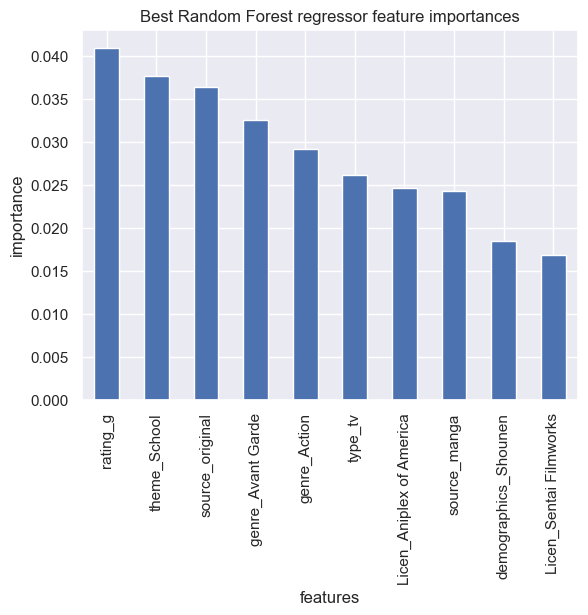

In [118]:
imps = modelRF.feature_importances_
imps[0:10]
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[0:10]
gb_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best Random Forest regressor feature importances')

Some positive features include, having a g rating, having a school theme, the source being original or manga, being a shounen show, being a tv show, being licesensed by either Aniplex or Sentai Filmworks, and having eitehr a genre of Avant garde or action

## Gradient Boosting

In [68]:
from sklearn.ensemble import GradientBoostingRegressor


gb_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    GradientBoostingRegressor(random_state=47)
)

In [69]:
gb_pipe.fit(X_train,y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(random_state=47))])

In [70]:
yGB_tr_pred = gb_pipe.predict(X_train)
yGB_te_pred = gb_pipe.predict(X_test)

In [71]:
#higher the better
print("Training set R2 score: ",r2_score(y_train, yGB_tr_pred))
print("Testing set R2 score: ",r2_score(y_test, yGB_te_pred))

Training set R2 score:  0.48577398169000985
Testing set R2 score:  0.46069815530344305


In [72]:
# lower the better
print("MAE of training set: ",mean_absolute_error(y_train, yGB_tr_pred)) 
print("MAE of testing set: ",mean_absolute_error(y_test, yGB_te_pred))

MAE of training set:  0.5085027012782941
MAE of testing set:  0.5165676029457434


In [73]:
print("RMSE of training set: ", np.sqrt(mean_squared_error(y_train, yGB_tr_pred)))
print("RMSE of the testing set: ", np.sqrt(mean_squared_error(y_test, yGB_te_pred)))

RMSE of training set:  0.6466633969881126
RMSE of the testing set:  0.6622612132400166


So far it seems that the random Forest has the best metrics in terms of having higher R2 scores, having a lower MAE scores and RMSE is also lower on RF. However, Gradient boosting has similar results for both the training and test scores, which is good, however this could be because the sample sized used was too small

Let's check out our cross validation scores

In [74]:
gb_cv_scores_test= cross_val_score(gb_pipe, X_test, y_test, cv=5)
gb_cv_scores_train= cross_val_score(gb_pipe, X_train, y_train, cv=5)

In [75]:
cv_scores_gb_test= gb_cv_scores_test.mean()
cv_scores_gb_train= gb_cv_scores_train.mean()
cv_scores_std_test_gb= gb_cv_scores_test.std()

In [76]:
print ('Mean cross validation test score: ' +str(cv_scores_gb_test))
print ('Mean cross validation train score: ' +str(cv_scores_gb_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_gb))

Mean cross validation test score: 0.4479875912877991
Mean cross validation train score: 0.4490223571670904
Standard deviation in cv test scores: 0.015564062712679511


In [103]:
modelgb= gb_pipe.named_steps['gradientboostingregressor']
modelgb.feature_importances_

array([0.00310514, 0.0109079 , 0.05790247, ..., 0.00508785, 0.00051293,
       0.03475011])

Text(0.5, 1.0, 'Best Gradient Boosting regressor feature importances')

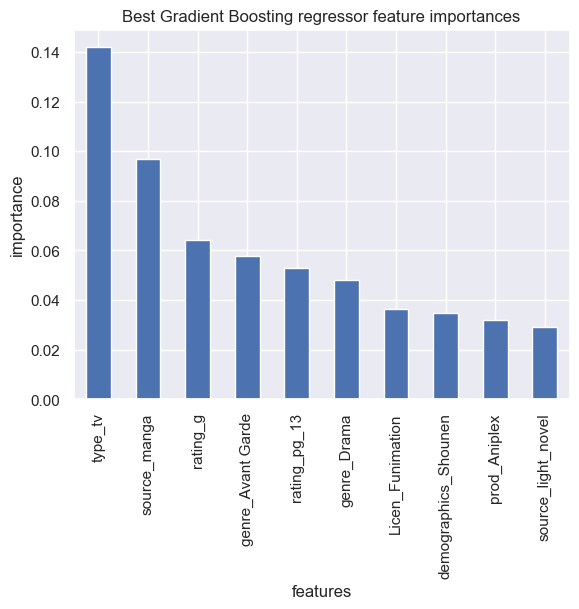

In [115]:
imps = modelgb.feature_importances_
imps[0:10]
gb_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)[0:10]
gb_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best Gradient Boosting regressor feature importances')

For the Gradient boosting Model, being a TV show, having a manga source and having either a g or pg13 rating, and being avant garde or drama will get higher scores 

Some of the high positive features match up with those from the ranomd forest model

Based on what has been done, I would choose the random Forest Model, due to the slightly better metrics. Due to some time constraints as well as over hour long execution time I could not perform more in depth tuning of the models parameters.  